In [1]:

#try:
#    os.chdir("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

## overhead
import sys
import os
import gc
from tqdm import tqdm

## data structures
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## embedding
# import umap

# model selection and tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, matthews_corrcoef

## models
from xgboost import XGBRegressor, XGBRFClassifier
from sklearn.linear_model import Lasso
from statsmodels.regression.linear_model import OLS

### load imputed data

In [2]:
celldyn = pd.read_feather("T:/laupodteam/AIOS/Chontira/CellDynClustering/data/cell_dyn_gender_Full_100_encoded.feather")
celldyn.columns = celldyn.columns.str.lower()
gc.collect()

celldyn = celldyn[celldyn.age >= 0]

### select independent variables and age

In [3]:
meas_cols = [c for c in celldyn if ('combo' in c) or ('c_b_' in c)]

In [4]:
from sklearn.base import BaseEstimator
class RegrSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = Lasso(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    # def predict_proba(self, X):
    #     return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [6]:
parameters = [
    {
        'regr__estimator': [Lasso()],
        
    },
    {
        'regr__estimator': [XGBRegressor()],
    },
]


In [7]:
pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("regr",Lasso())
])


### EDA of original data

In [4]:
cll_patients= pd.read_sas("T:/lab_research\RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/cll_nums.sas7bdat",encoding='latin-1')
cll_patients['upod_id'] = cll_patients.upod_id.astype(int).astype(str)
cll_patients['afname_dt']  = cll_patients.fcs_id.str.extract(r"(\d{8})").astype(str).apply(pd.to_datetime)

In [5]:
or_data = pd.read_sas("T:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_Researchdata/celldyn.sas7bdat")

In [6]:
or_data['afname_dt'] = or_data.afname_dt.astype('datetime64[ns, Europe/Berlin]')

C:\Users\hjoosse3\AppData\Local\Temp\ipykernel_12868\2894758853.py:1: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  or_data['afname_dt'] = or_data.afname_dt.astype('datetime64[ns, Europe/Berlin]')


In [7]:
or_data.columns = [c.lower() for c in or_data]

In [8]:
int_df = or_data.loc[or_data.fcs_id.str.decode('latin-1').isin(cll_patients.fcs_id)];
celldyn['is_cll'] = np.where(celldyn.studyid_alle_celldyn.isin(int_df.studyid_alle_celldyn),1,0)

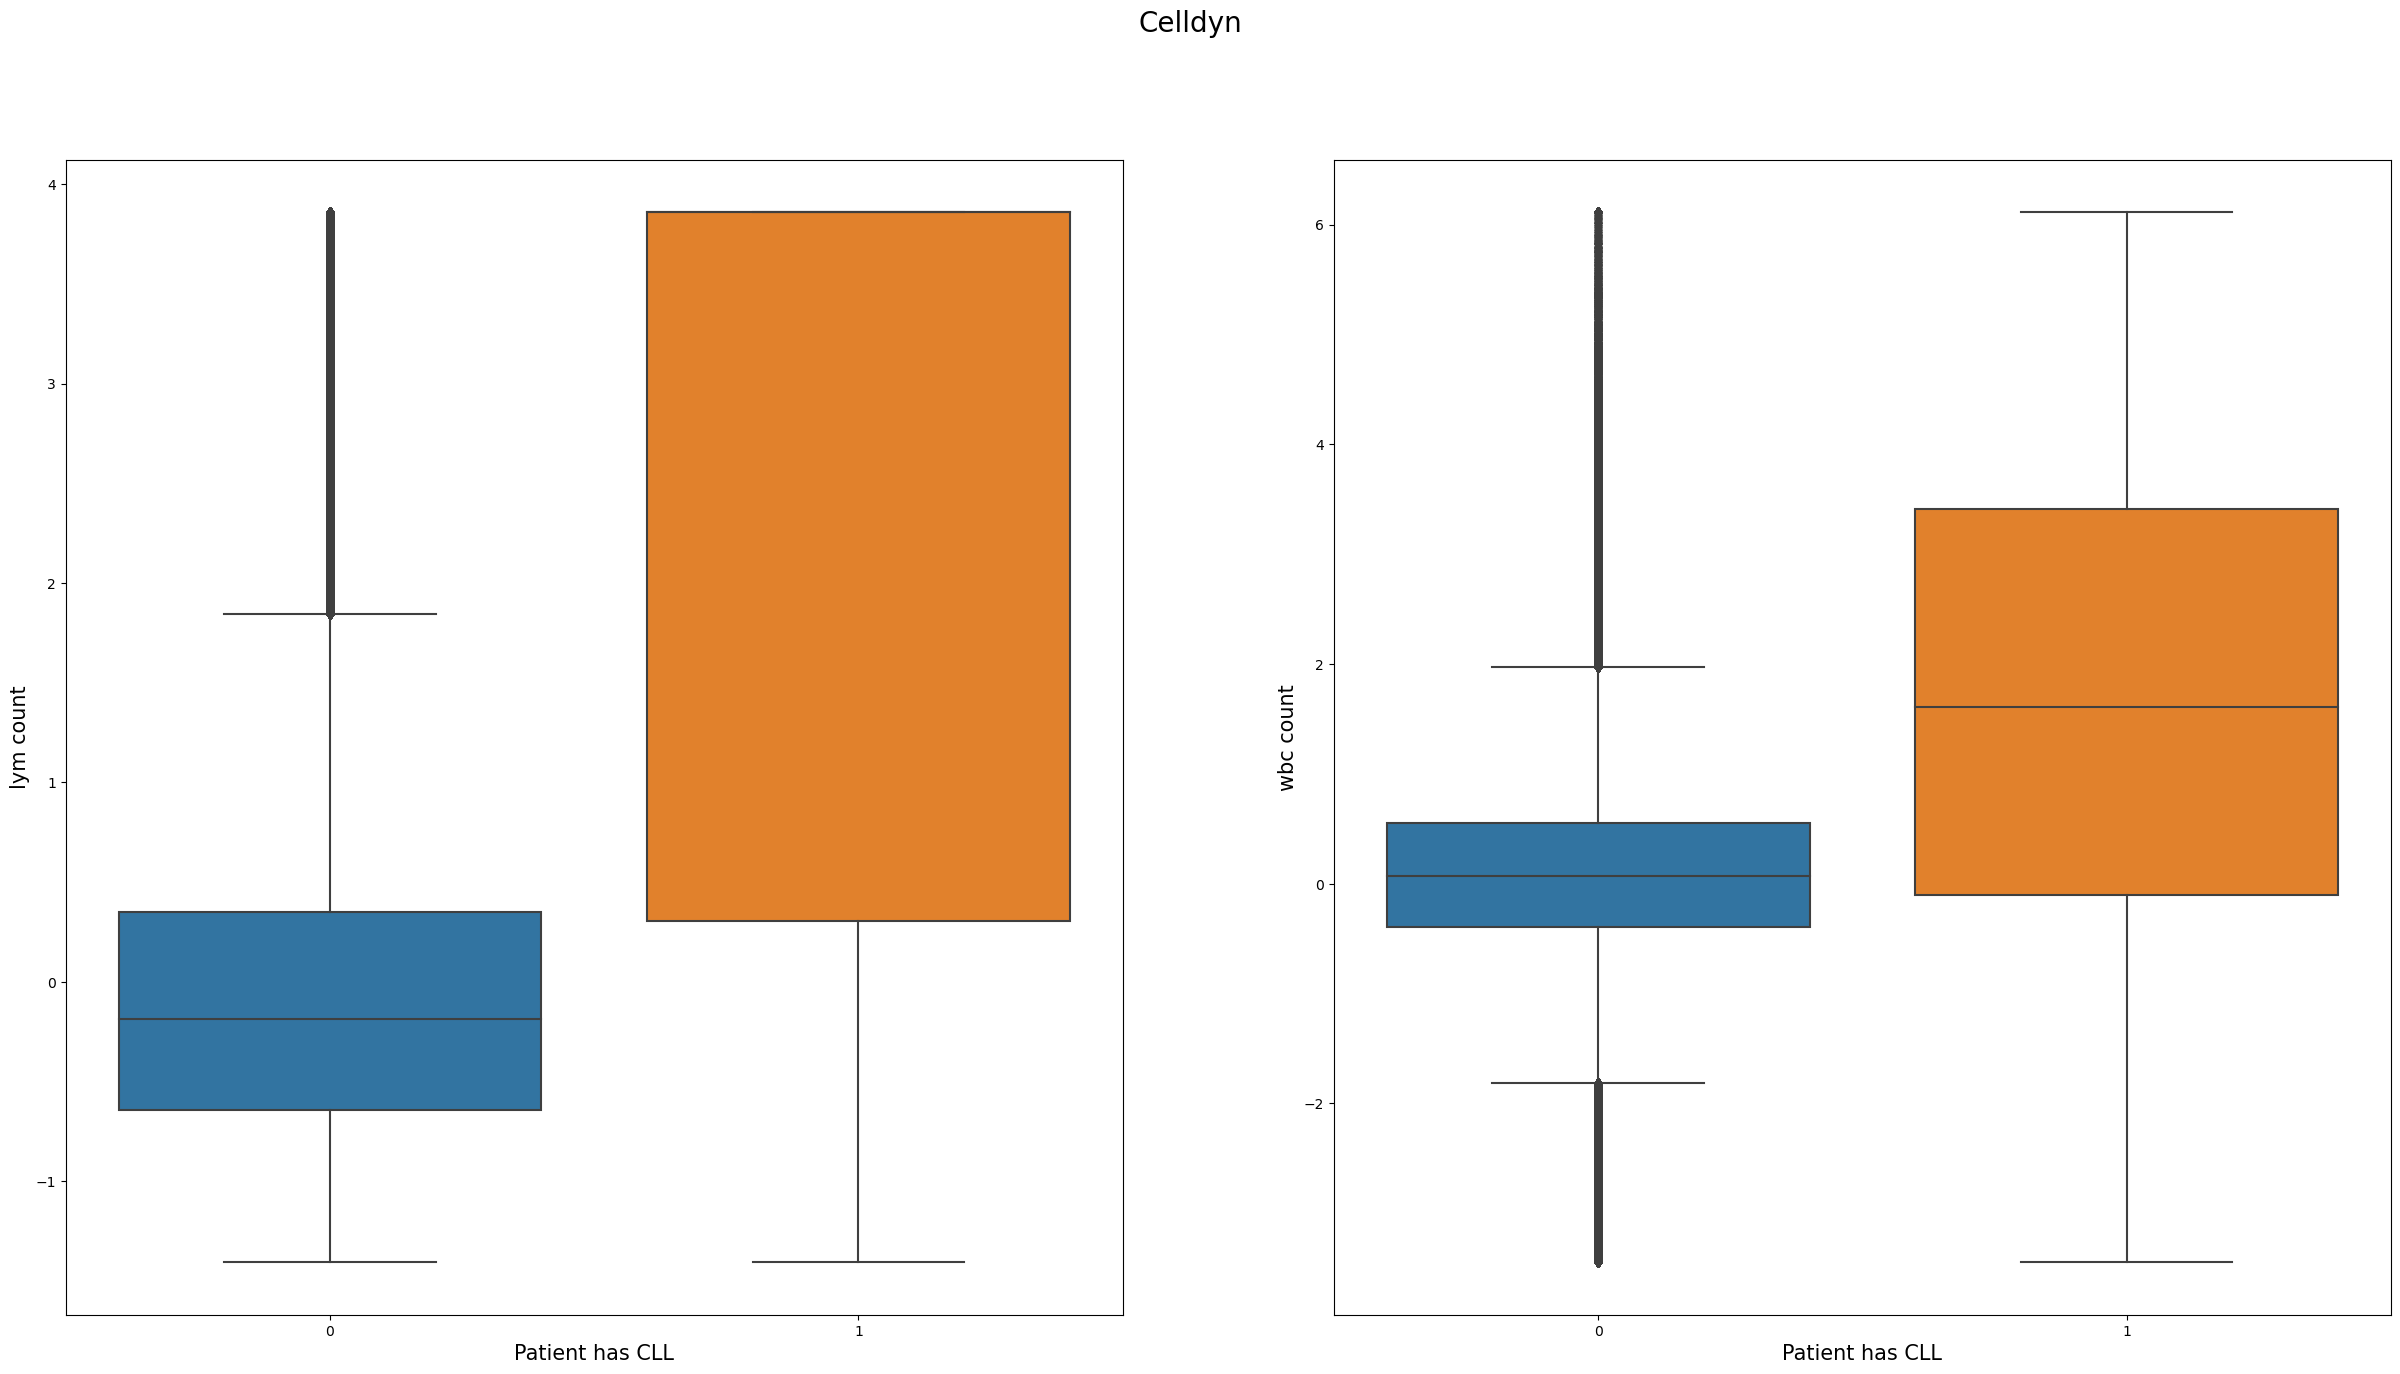

In [57]:
fig, ax = plt.subplots(1,2,figsize = (30,15),sharex='col')
i,j = 0,0

for col in ['c_b_lym','c_b_wbc']:
    
    sns.boxplot(x = celldyn.is_cll,y = celldyn[col],ax = ax[i])
    ax[i].set_ylabel(f"{col[-3:]} count",fontsize = 15)
    ax[i].set_xlabel(f"Patient has CLL",fontsize = 15)
    j += 1 if i == 2 else 0
    i += 1 if i < 2 else -2

fig.suptitle('Celldyn',fontsize = 20)
plt.savefig("../artifacts/CLL_in_celldyn.png",dpi = 300,bbox_inches = 'tight')
plt.savefig("../artifacts/CLL_in_celldyn.eps",dpi = 300,bbox_inches = 'tight')

In [62]:
plot_df = celldyn[meas_cols+['age','gender','is_cll']].sample(50000)

# fig, ax = plt.subplots(33,3,figsize = (30,80),sharex='col')
# i,j = 0,0

# for col in meas_cols:
#     ax[j,i].scatter(plot_df.age,plot_df[col],c = plot_df.is_cll,alpha = 0.3,s = 1)
#     ax[j,i].set_title(col)
#     j += 1 if i == 2 else 0
#     i += 1 if i < 2 else -2


<Axes: xlabel='age', ylabel='c_b_mchc'>

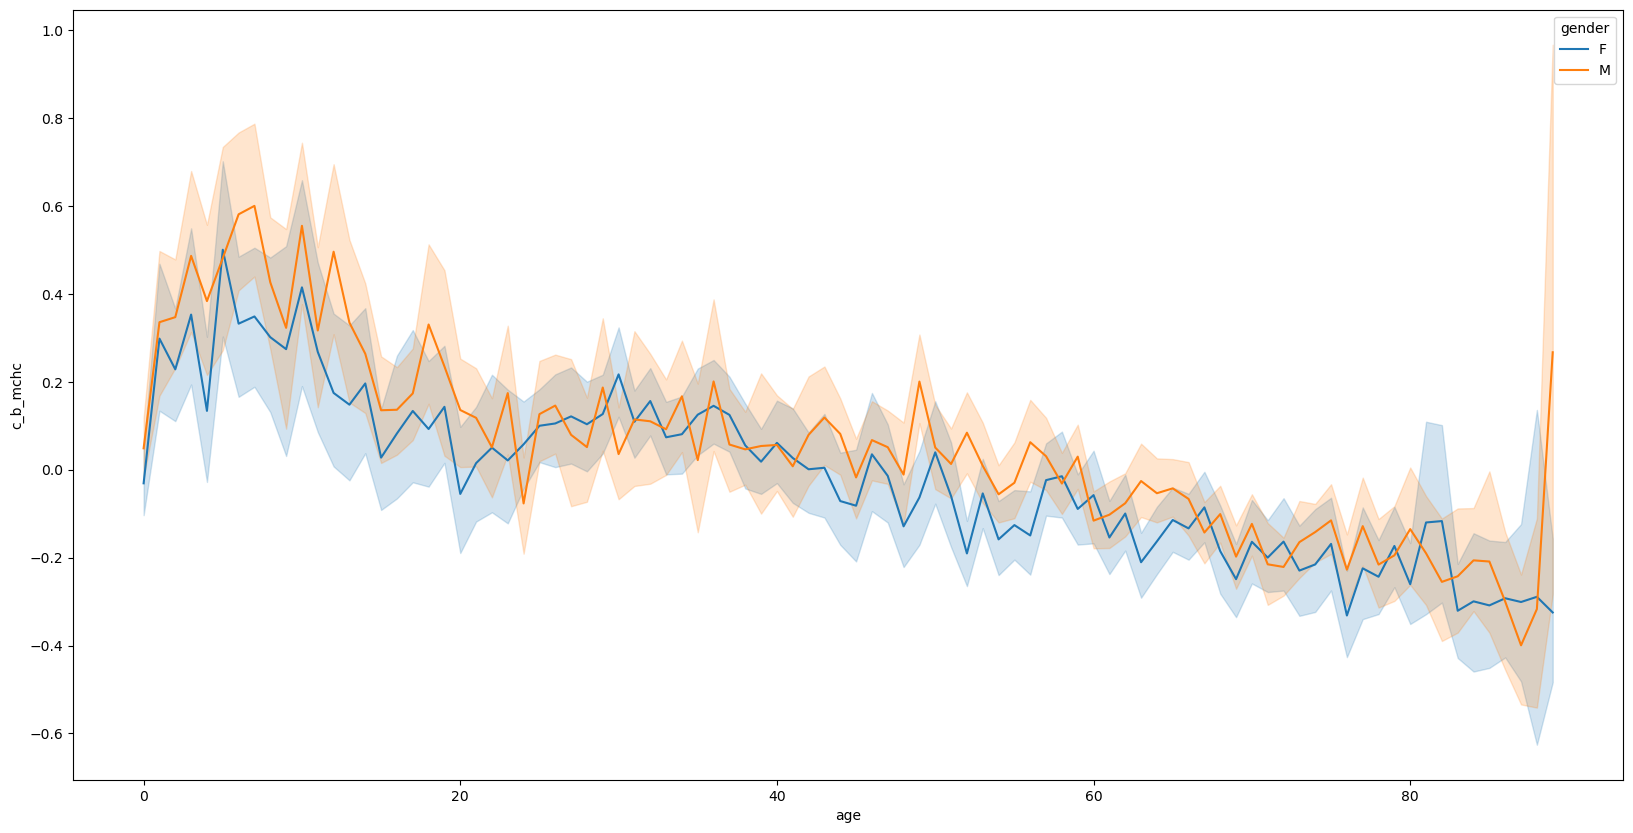

In [64]:
plt.figure(figsize = (20,10))
sns.lineplot(data = plot_df.loc[lambda x:(x.age < 90)], x = 'age',y = 'c_b_mchc' , hue = 'gender')


### EDA of UMAP

In [9]:
emb_data = pd.read_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/cell_dyn_UMAP_embedded_dim_6_MF100.feather")
emb_data = emb_data.loc[emb_data.age >= 0]
emb_data['is_cll'] = celldyn.is_cll
emb_data.shape

(3093785, 13)

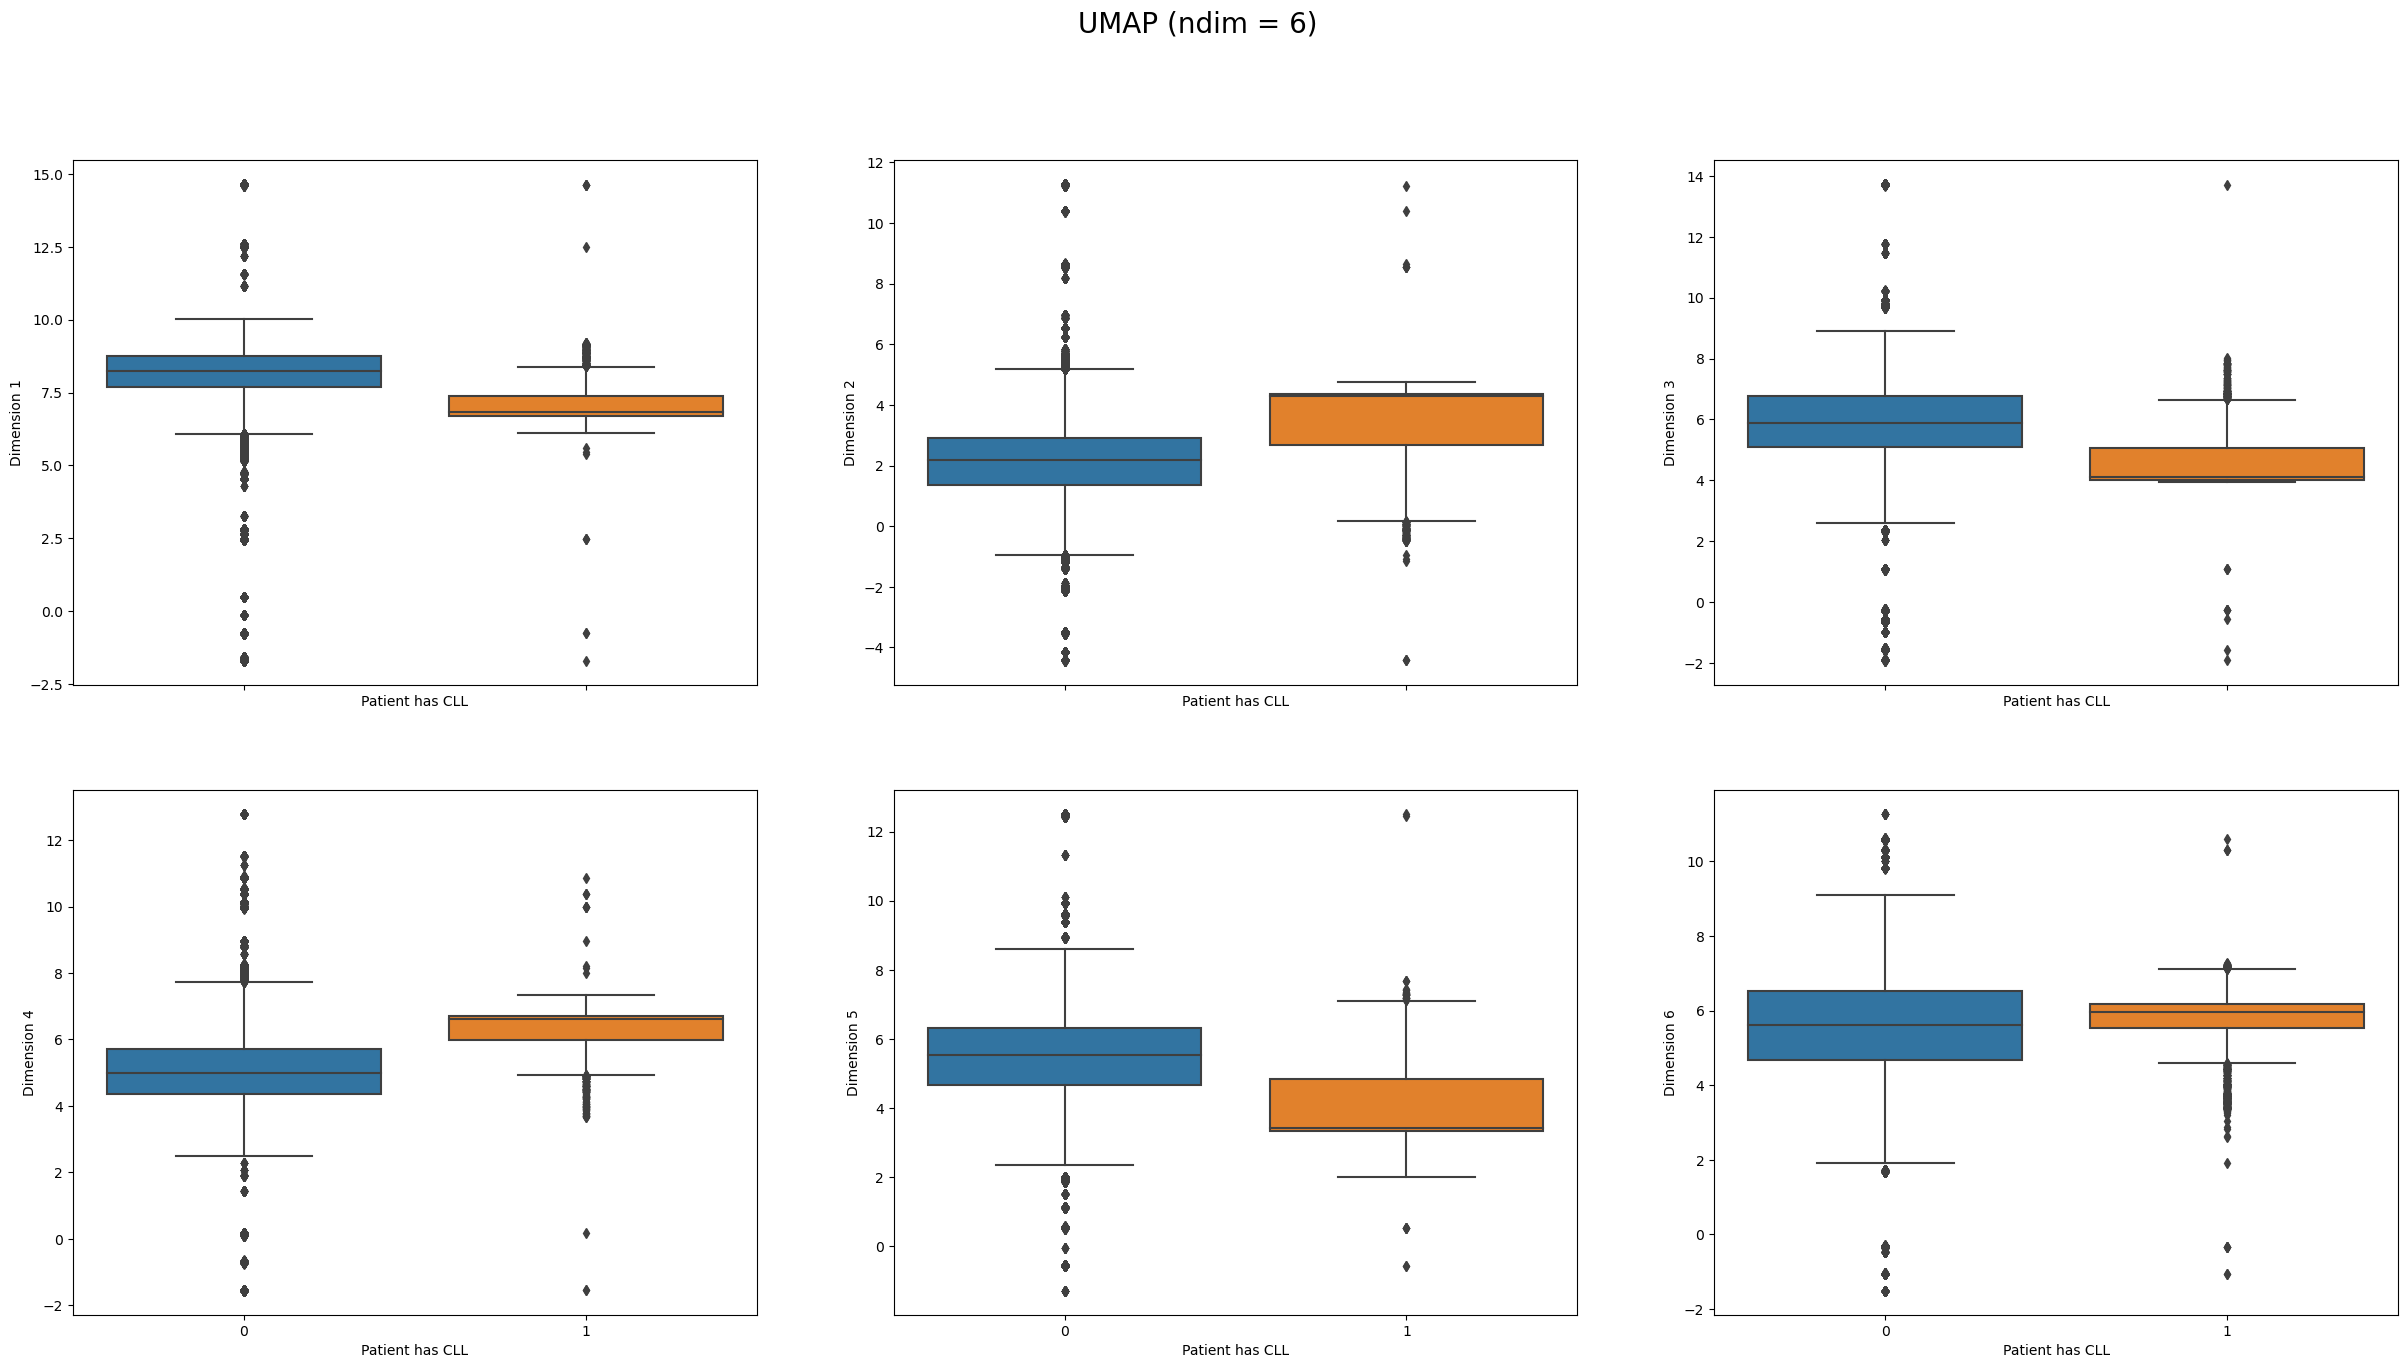

In [56]:
fig, ax = plt.subplots(2,3,figsize = (30,15),sharex='col')
i,j = 0,0

for col in emb_data.columns[:6]:
    
    sns.boxplot(x = emb_data.is_cll,y = emb_data[col],ax = ax[j,i])
    ax[j,i].set_ylabel(f"Dimension {col[-1]}")
    ax[j,i].set_xlabel(f"Patient has CLL")
    j += 1 if i == 2 else 0
    i += 1 if i < 2 else -2

fig.suptitle('UMAP (ndim = 6)',fontsize = 20)
plt.savefig("../artifacts/CLL_in_UMAP_ndim6.png",dpi = 300,bbox_inches = 'tight')
plt.savefig("../artifacts/CLL_in_UMAP_ndim6.eps",dpi = 300,bbox_inches = 'tight')

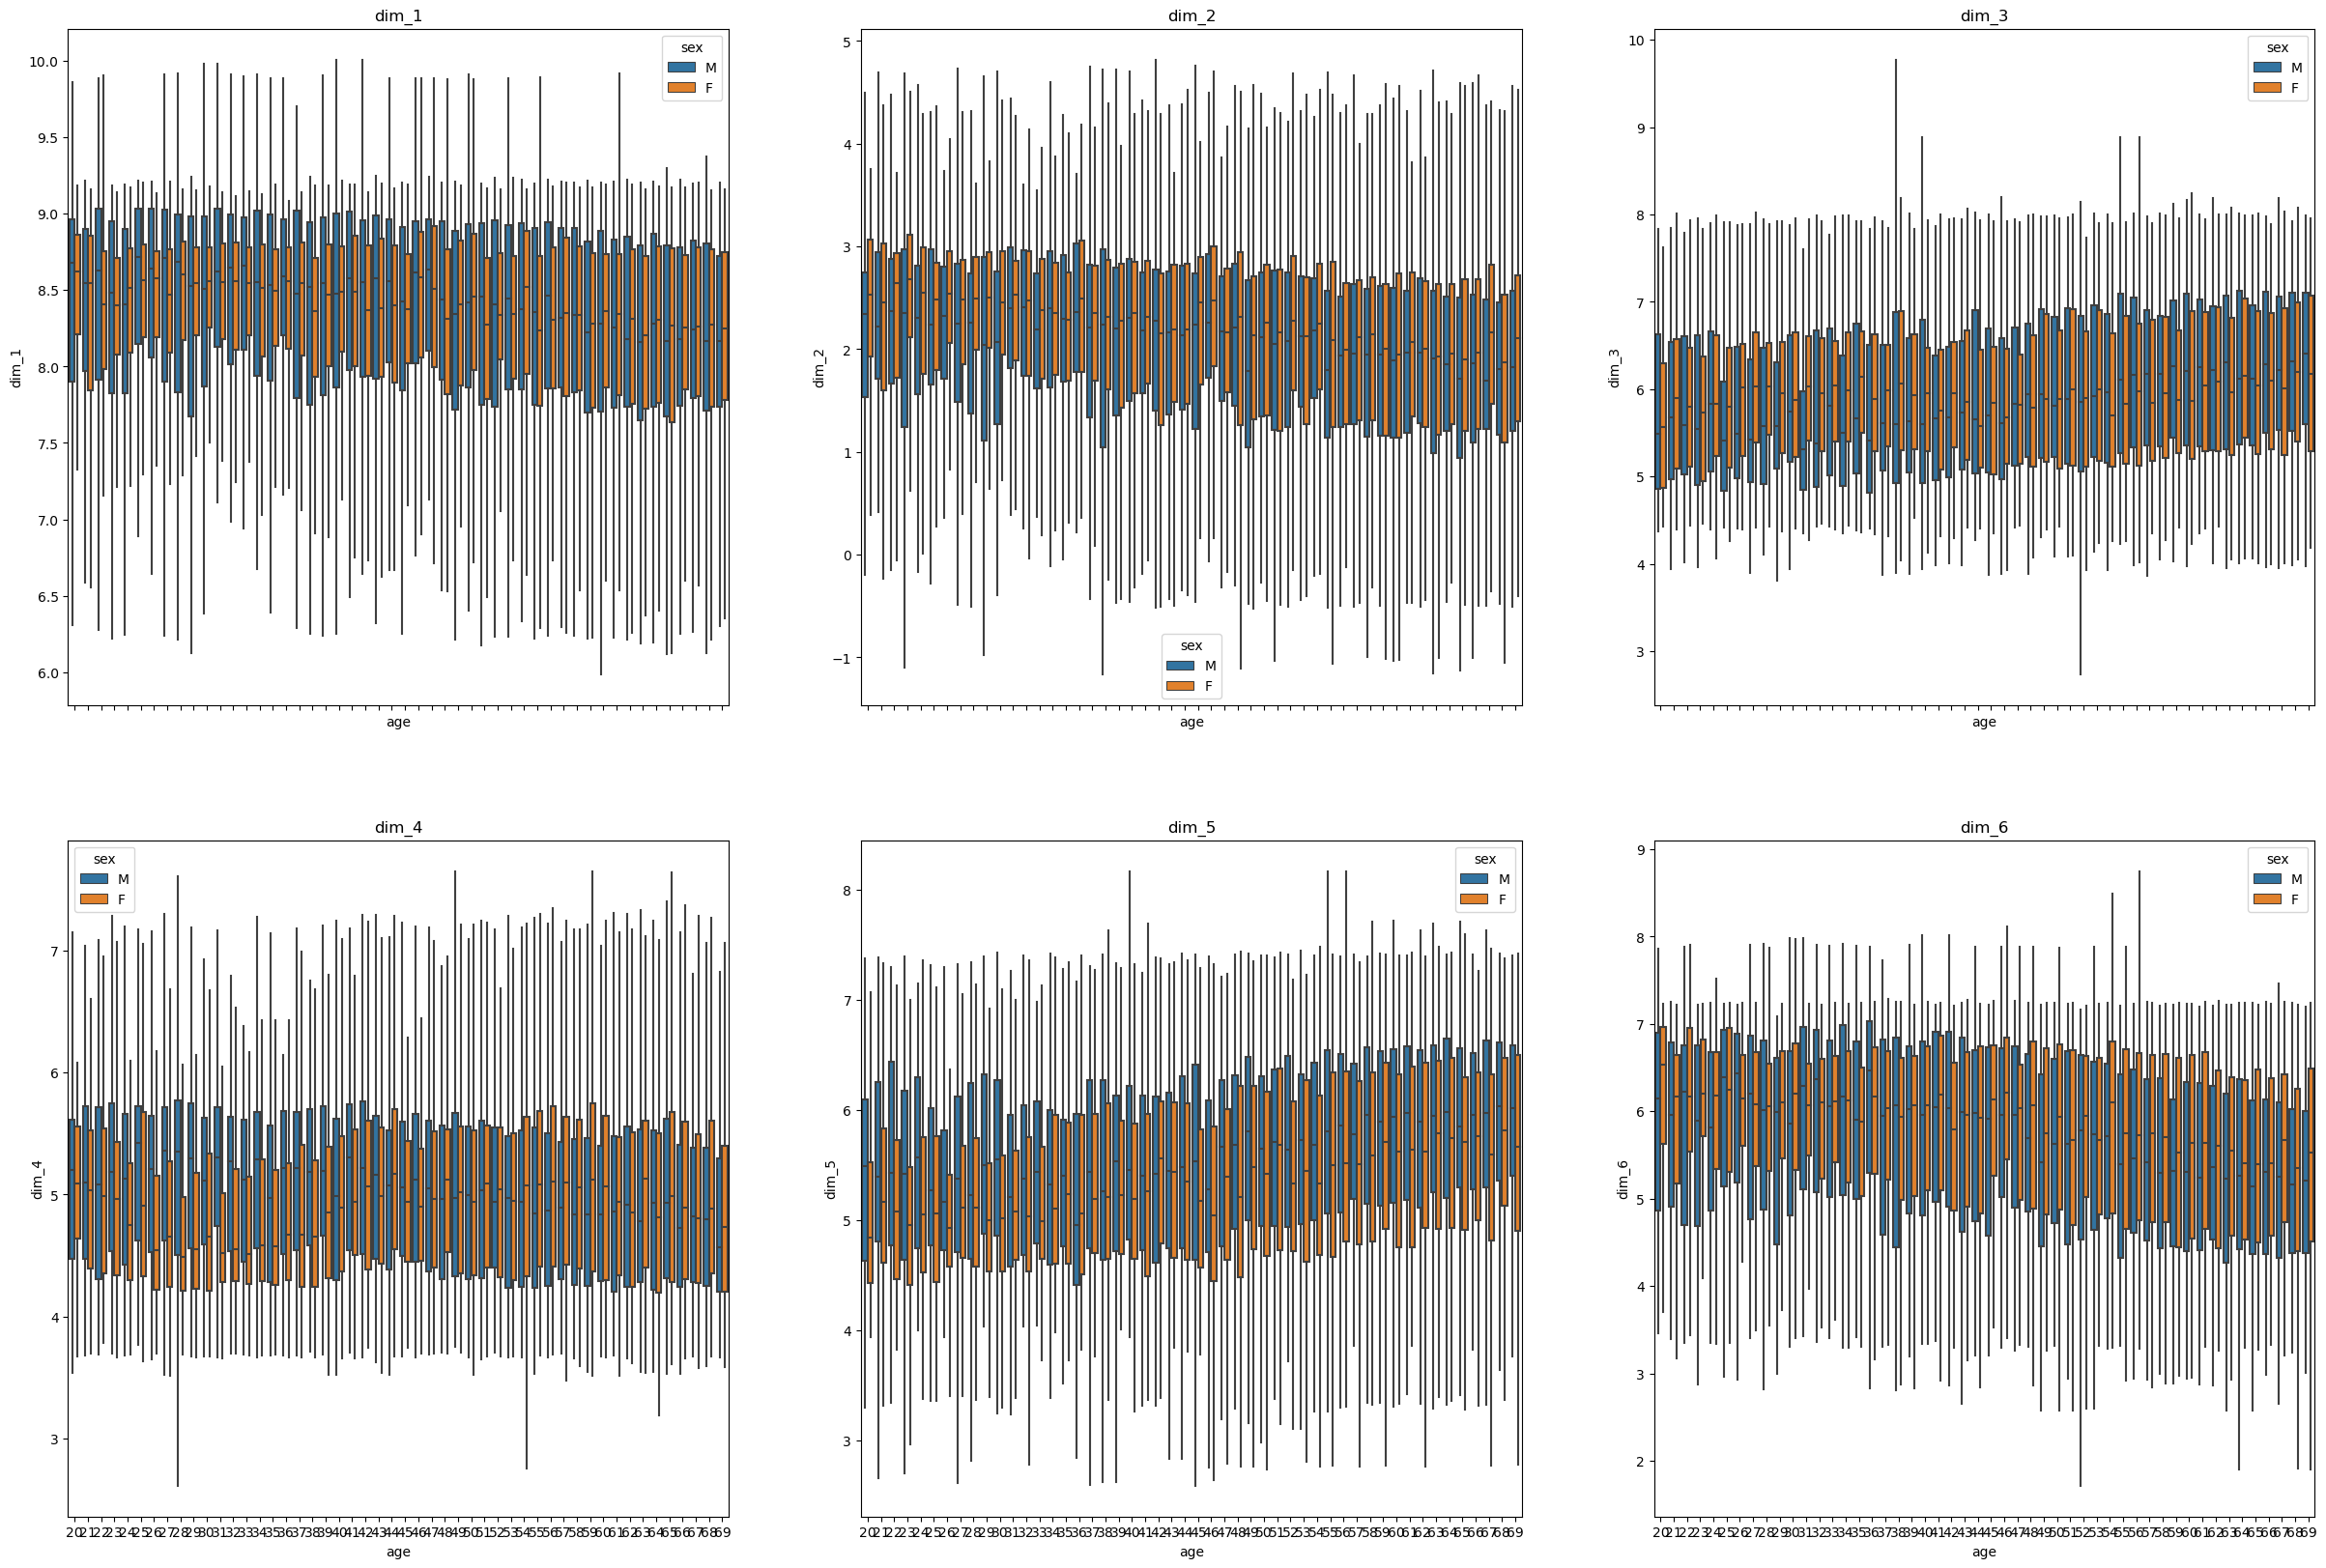

In [22]:
plot_df = emb_data[lambda x:(x.age < 70) & (x.age>=20)].sample(20000)

fig, ax = plt.subplots(2,3,figsize = (30,20),sharex='col')
i,j = 0,0

for col in emb_data.columns[:6]:
    sns.boxplot(x=plot_df.age,y=plot_df[col],hue = plot_df.sex,ax = ax[j,i],showfliers = False,showcaps=False)
    ax[j,i].set_title(col)
    j += 1 if i == 2 else 0
    i += 1 if i < 2 else -2


### TRIMAP 

In [10]:
trimap_data = pd.read_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/cell_dyn_trimap_embedded_dim_6_MF100.feather")
trimap_data = trimap_data.loc[trimap_data.age >= 0]
trimap_data['is_cll'] = celldyn.is_cll

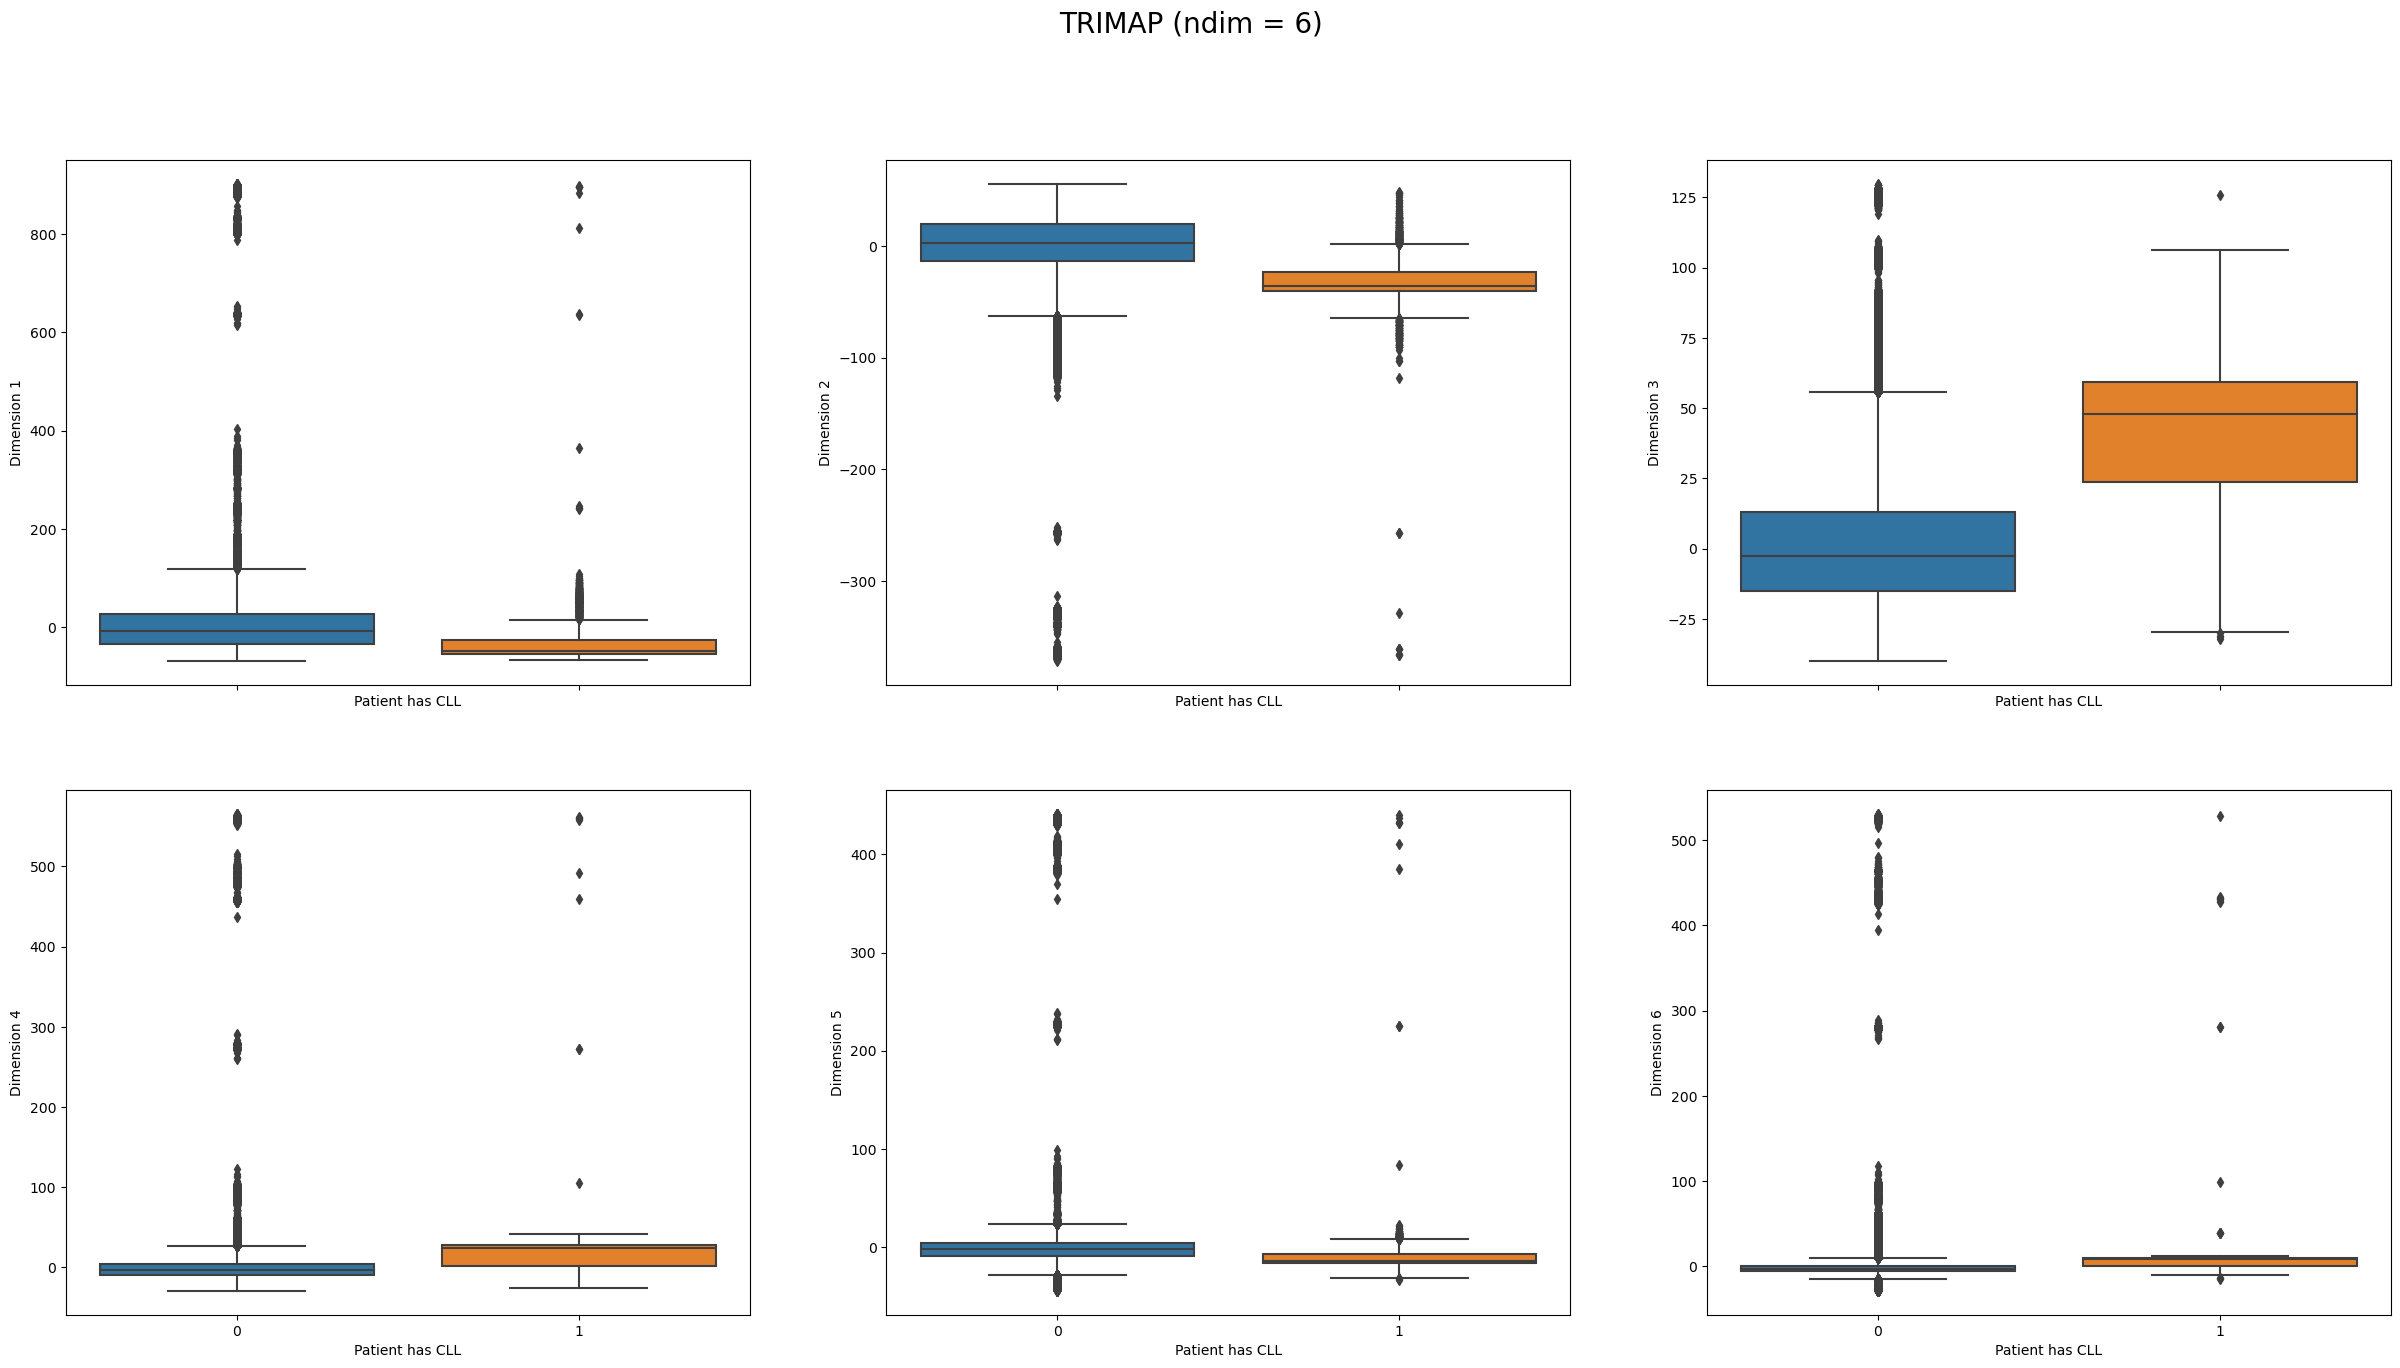

In [55]:
fig, ax = plt.subplots(2,3,figsize = (30,15),sharex='col')
i,j = 0,0

for col in trimap_data.columns[:6]:
    
    sns.boxplot(x = trimap_data.is_cll,y = trimap_data[col],ax = ax[j,i])
    ax[j,i].set_ylabel(f"Dimension {col[-1]}")
    ax[j,i].set_xlabel(f"Patient has CLL")
    j += 1 if i == 2 else 0
    i += 1 if i < 2 else -2

fig.suptitle('TRIMAP (ndim = 6)',fontsize = 20)
plt.savefig("../artifacts/CLL_in_TRIMAP_ndim6.png",dpi = 300,bbox_inches = 'tight')
plt.savefig("../artifacts/CLL_in_TRIMAP_ndim6.eps",dpi = 300,bbox_inches = 'tight')

### comparing XGB for sex prediction

between ages 20 and 50 (because this should be apparent in the data)

In [12]:
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef

#### original data

In [43]:
X = celldyn.loc[lambda x:(x.age >= 20) & (x.age<=50),meas_cols].to_numpy(dtype=np.float32)
y = np.where(celldyn.loc[lambda x:(x.age >= 20) & (x.age<=50)].gender != "F",0,1)

sample = np.random.choice(range(X.shape[0]),size = 200000,replace=False)
sample_train = np.random.choice(sample,size = 170000, replace=False)
sample_test = np.setdiff1d(sample,sample_train)

In [44]:
from datetime import datetime as dt

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]

time_org = []

inner_validation_org = dict(acc=[],MCC=[])
outer_validation_org = dict(acc=[],MCC=[])
for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    
    inner_validation_org['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_org['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_org['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_org['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))
    
    time_org.append(dt.now() - start_fold)
    



#### embedded data

In [46]:
X = emb_data.loc[lambda x:(x.age >= 20) & (x.age<=50),[f'dim_{i}' for i in range(1,7)]].to_numpy(dtype=np.float32)
y = np.where(emb_data.loc[lambda x:(x.age >= 20) & (x.age<=50)].sex != "F",0,1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]


time_emb = []
inner_validation_emb = dict(acc=[],MCC=[])
outer_validation_emb = dict(acc=[],MCC=[])

for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    inner_validation_emb['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_emb['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_emb['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_emb['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))

    time_emb.append(dt.now() - start_fold)

#### TRIMAP

In [47]:
X = trimap_data.loc[lambda x:(x.age >= 20) & (x.age<=50),[f'dim_{i}' for i in range(1,7)]].to_numpy(dtype=np.float32)
y = np.where(trimap_data.loc[lambda x:(x.age >= 20) & (x.age<=50)].sex != "F",0,1)


scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]


time_trimap = []
inner_validation_trimap = dict(acc=[],MCC=[])
outer_validation_trimap = dict(acc=[],MCC=[])

for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    inner_validation_trimap['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_trimap['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_trimap['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_trimap['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))

    time_trimap.append(dt.now() - start_fold)

#### PCA

In [48]:
from sklearn.decomposition import PCA


In [49]:
pc = PCA(n_components=6)
pca_dat = pd.DataFrame(pc.fit_transform(celldyn[meas_cols]),columns = [f'dim_{i}' for i in range(1,7)])
pca_dat['age'] = celldyn.reset_index().age
pca_dat['sex'] = celldyn.reset_index().gender
pca_dat['is_cll'] = celldyn.reset_index().is_cll

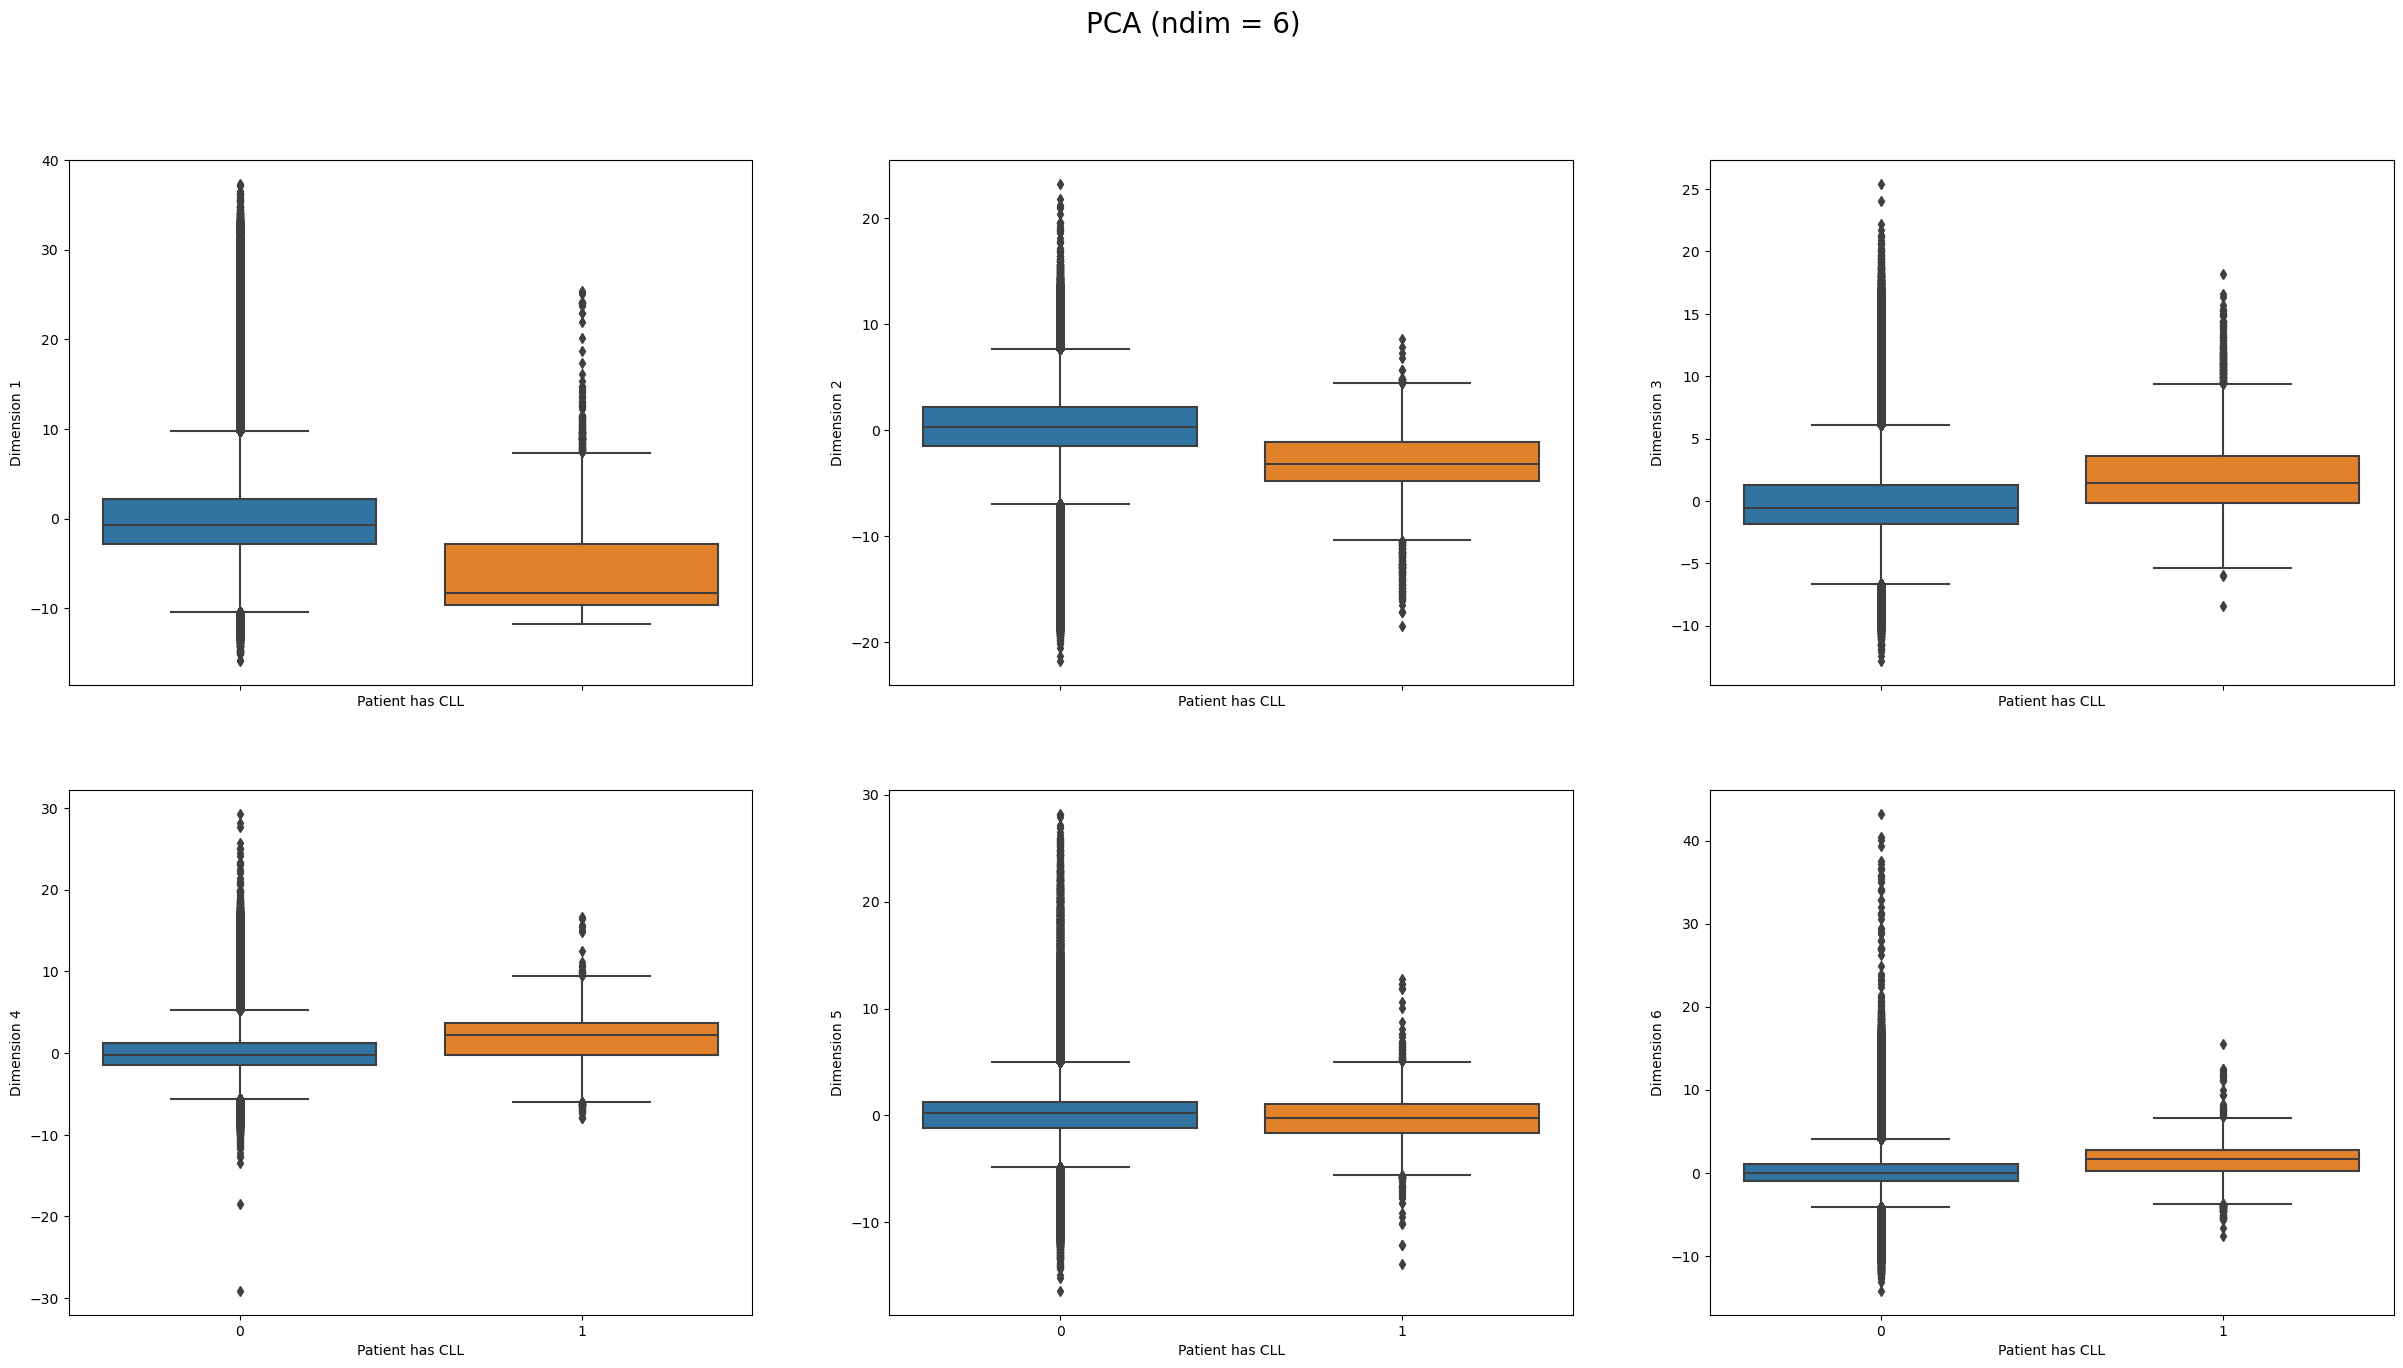

In [50]:
fig, ax = plt.subplots(2,3,figsize = (30,15),sharex='col')
i,j = 0,0

for col in pca_dat.columns[:6]:
    
    sns.boxplot(x = pca_dat.is_cll,y = pca_dat[col],ax = ax[j,i])
    ax[j,i].set_ylabel(f"Dimension {col[-1]}")
    ax[j,i].set_xlabel(f"Patient has CLL")
    j += 1 if i == 2 else 0
    i += 1 if i < 2 else -2

fig.suptitle('PCA (ndim = 6)',fontsize = 20)
plt.savefig("../artifacts/CLL_in_PCA_ndim6.png",dpi = 300,bbox_inches = 'tight')
plt.savefig("../artifacts/CLL_in_PCA_ndim6.eps",dpi = 300,bbox_inches = 'tight')

In [51]:
X = pca_dat.loc[lambda x:(x.age >= 20) & (x.age<=50),[f'dim_{i}' for i in range(1,7)]].to_numpy(dtype=np.float32)
y = np.where(pca_dat.loc[lambda x:(x.age >= 20) & (x.age<=50)].sex != "F",0,1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]

time_pca = []
inner_validation_pca = dict(acc=[],MCC=[])
outer_validation_pca = dict(acc=[],MCC=[])

for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    inner_validation_pca['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_pca['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_pca['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_pca['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))

    time_pca.append(dt.now() - start_fold)    

#### plot results

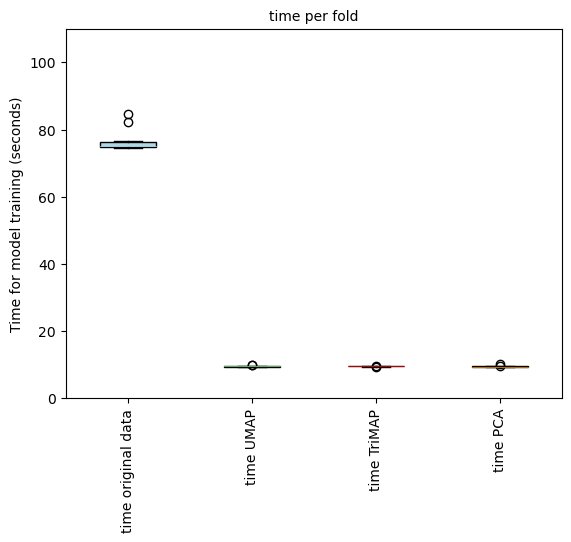

In [52]:
plt.style.use("default")


fig = plt.boxplot(
    [
        [x.total_seconds() for x in time_org],
        [x.total_seconds() for x in time_emb],
        [x.total_seconds() for x in time_trimap],
        [x.total_seconds() for x in time_pca]
        
    ],
    labels=[
        'time original data', 'time UMAP', 'time TriMAP','time PCA'
    ],
    patch_artist=True,
)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize = 10)

colors = ['lightblue', 'lightgreen', 'red','orange']
for patch,median, color in zip(fig['boxes'],fig['medians'], colors):
    patch.set_facecolor(color)
    median.set_color(color)
    median.set_linewidth(0.5)

plt.ylabel("Time for model training (seconds)",fontdict=dict(size = 10))
plt.ylim(0,110)
plt.title("time per fold",fontdict=dict(size=10))


plt.savefig("../artifacts/time_for_xgboost_training_men_vs_women.png",dpi = 300,bbox_inches='tight')
plt.savefig("../artifacts/time_for_xgboost_training_men_vs_women.eps",dpi = 300,bbox_inches='tight')

# plt.boxplot([outer_validation_org['acc'],outer_validation_emb['acc']],labels=['title 1','title 2'])


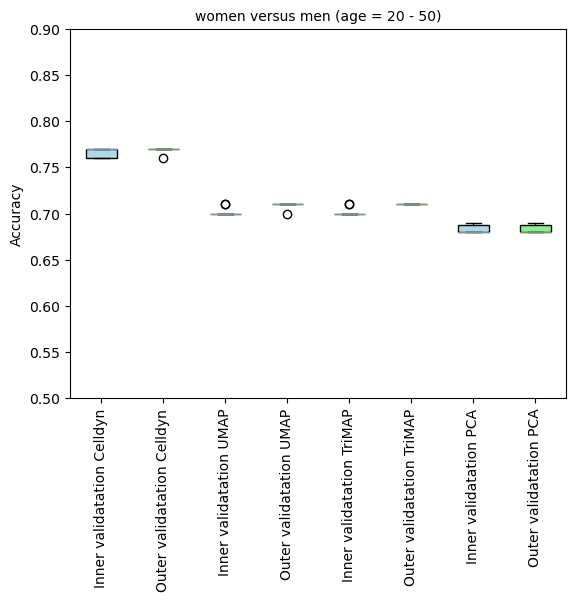

In [53]:
plt.style.use("default")


fig = plt.boxplot(
    [
        inner_validation_org['acc'],outer_validation_org['acc'],
        inner_validation_emb['acc'],outer_validation_emb['acc'],
        inner_validation_trimap['acc'],outer_validation_trimap['acc'],
        inner_validation_pca['acc'],inner_validation_pca['acc']
        
    ],
    labels=[
    'Inner validatation Celldyn','Outer validatation Celldyn',
    'Inner validatation UMAP','Outer validatation UMAP',
    'Inner validatation TriMAP','Outer validatation TriMAP',
    'Inner validatation PCA','Outer validatation PCA'
    ],
    patch_artist=True,
)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize = 10)

colors = ['lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen']
for patch,median, color in zip(fig['boxes'],fig['medians'], colors):
    patch.set_facecolor(color)
    median.set_color(color)
    median.set_linewidth(0.5)

plt.ylabel("Accuracy",fontdict=dict(size = 10))
plt.ylim(0.5,0.9)
plt.title("women versus men (age = 20 - 50)",fontdict=dict(size=10))


plt.savefig("../artifacts/women_vs_men_acc_20_50.png",dpi = 300,bbox_inches='tight')
plt.savefig("../artifacts/women_vs_men_acc_20_50.eps",dpi = 300,bbox_inches='tight')


# plt.boxplot([outer_validation_org['acc'],outer_validation_emb['acc']],labels=['title 1','title 2'])


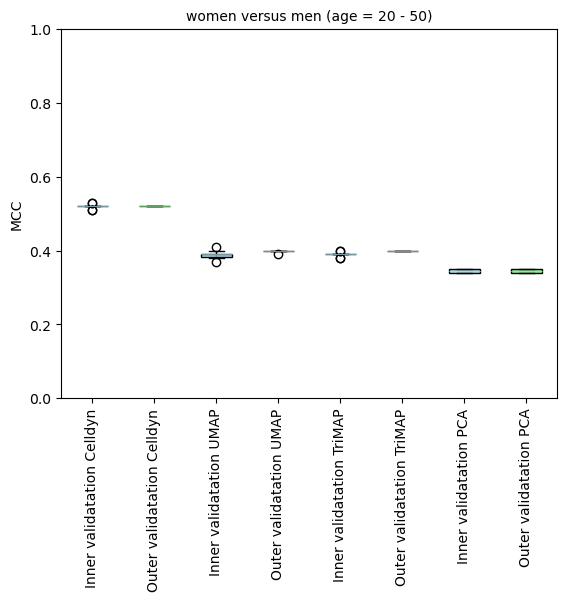

In [54]:

fig = plt.boxplot(
    [
        inner_validation_org['MCC'],outer_validation_org['MCC'],
        inner_validation_emb['MCC'],outer_validation_emb['MCC'],
        inner_validation_trimap['MCC'],outer_validation_trimap['MCC'],        
        inner_validation_pca['MCC'],inner_validation_pca['MCC']
        
    ],
    labels=[
    'Inner validatation Celldyn','Outer validatation Celldyn',
    'Inner validatation UMAP','Outer validatation UMAP',
    'Inner validatation TriMAP','Outer validatation TriMAP',
    'Inner validatation PCA','Outer validatation PCA'
    ],
    patch_artist=True,
)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize = 10)


colors = ['lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen']
for patch,median, color in zip(fig['boxes'],fig['medians'], colors):
    patch.set_facecolor(color)
    median.set_color(color)
    median.set_linewidth(0.5)

plt.ylabel("MCC",fontdict=dict(size = 10))
plt.ylim(0,1)
plt.title("women versus men (age = 20 - 50)",fontdict=dict(size=10))


plt.savefig("../artifacts/women_vs_men_mcc_20_50.png",dpi = 300,bbox_inches='tight')
plt.savefig("../artifacts/women_vs_men_mcc_20_50.eps",dpi = 300,bbox_inches='tight')

# plt.boxplot([outer_validation_org['acc'],outer_validation_emb['acc']],labels=['title 1','title 2'])


### Comparing XGB for Old versus Young prediction

Predicting the younger versus the older patients

In [31]:
X = celldyn.loc[lambda x:(x.age <= 20) | (x.age>=60),meas_cols].to_numpy(dtype=np.float32)
y = np.where(celldyn.loc[lambda x:(x.age <= 20) | (x.age>= 60)].age >= 60,1,0)

sample = np.random.choice(range(X.shape[0]),size = 200000,replace=False)
sample_train = np.random.choice(sample,size = 170000, replace=False)
sample_test = np.setdiff1d(sample,sample_train)

In [32]:
from datetime import datetime as dt

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]

time_org = []

inner_validation_org = dict(acc=[],MCC=[])
outer_validation_org = dict(acc=[],MCC=[])
for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    
    inner_validation_org['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_org['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_org['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_org['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))
    
    time_org.append(dt.now() - start_fold)
    



#### embedded data

In [34]:
X = emb_data.loc[lambda x:(x.age <= 20) | (x.age >= 60),[f'dim_{i}' for i in range(1,7)]].to_numpy(dtype=np.float32)
y = np.where(emb_data.loc[lambda x:(x.age <= 20) | (x.age >= 60)].age >= 60,1,0)


scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]


time_emb = []
inner_validation_emb = dict(acc=[],MCC=[])
outer_validation_emb = dict(acc=[],MCC=[])

for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    inner_validation_emb['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_emb['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_emb['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_emb['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))

    time_emb.append(dt.now() - start_fold)

#### TRIMAP

In [35]:
X = trimap_data.loc[lambda x:(x.age <= 20) | (x.age >= 60),[f'dim_{i}' for i in range(1,7)]].to_numpy(dtype=np.float32)
y = np.where(trimap_data.loc[lambda x:(x.age <= 20) | (x.age >= 60)].age >= 60,1,0)


scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]


time_trimap = []
inner_validation_trimap = dict(acc=[],MCC=[])
outer_validation_trimap = dict(acc=[],MCC=[])

for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    inner_validation_trimap['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_trimap['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_trimap['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_trimap['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))

    time_trimap.append(dt.now() - start_fold)

#### PCA

In [36]:
from sklearn.decomposition import PCA


In [37]:
pc = PCA(n_components=6)
pca_dat = pd.DataFrame(pc.fit_transform(celldyn[meas_cols]),columns = [f'dim_{i}' for i in range(1,7)])
pca_dat['age'] = celldyn.reset_index().age
pca_dat['sex'] = celldyn.reset_index().gender
pca_dat['is_cll'] = celldyn.reset_index().is_cll

In [38]:
X = pca_dat.loc[lambda x:(x.age <= 20) | (x.age >= 60),[f'dim_{i}' for i in range(1,7)]].to_numpy(dtype=np.float32)
y = np.where(pca_dat.loc[lambda x:(x.age <= 20) | (x.age >= 60)].age >= 60,1,0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X[sample_train,:])
X_test = scaler.transform(X[sample_test,:])

y_train = y[sample_train]
y_test = y[sample_test]

time_pca = []
inner_validation_pca = dict(acc=[],MCC=[])
outer_validation_pca = dict(acc=[],MCC=[])

for train,test in KFold(n_splits=10).split(X_train,y_train):
    start_fold = dt.now()
    mod = xgb.XGBClassifier(max_depth = 3,n_estimators = 250)
    mod.fit(X_train[train],y_train[train])
    y_pred_in = mod.predict(X_train[test])
    y_pred_out = mod.predict(X_test)

    inner_validation_pca['acc'].append(np.round(accuracy_score(y_train[test],y_pred_in),2))
    inner_validation_pca['MCC'].append(np.round(matthews_corrcoef(y_train[test],y_pred_in),2))
    
    outer_validation_pca['acc'].append(np.round(accuracy_score(y_test,y_pred_out),2))
    outer_validation_pca['MCC'].append(np.round(matthews_corrcoef(y_test,y_pred_out),2))

    time_pca.append(dt.now() - start_fold)    

#### plot results

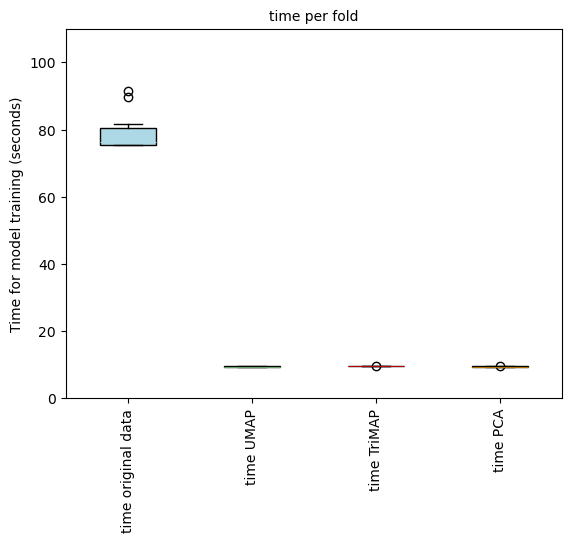

In [39]:
plt.style.use("default")


fig = plt.boxplot(
    [
        [x.total_seconds() for x in time_org],
        [x.total_seconds() for x in time_emb],
        [x.total_seconds() for x in time_trimap],
        [x.total_seconds() for x in time_pca]
        
    ],
    labels=[
        'time original data', 'time UMAP', 'time TriMAP','time PCA'
    ],
    patch_artist=True,
)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize = 10)

colors = ['lightblue', 'lightgreen', 'red','orange']
for patch,median, color in zip(fig['boxes'],fig['medians'], colors):
    patch.set_facecolor(color)
    median.set_color(color)
    median.set_linewidth(0.5)

plt.ylabel("Time for model training (seconds)",fontdict=dict(size = 10))
plt.ylim(0,110)
plt.title("time per fold",fontdict=dict(size=10))


plt.savefig("../artifacts/time_for_xgboost_training_old_vs_young.png",dpi = 300,bbox_inches='tight')
plt.savefig("../artifacts/time_for_xgboost_training_old_vs_young.eps",dpi = 300,bbox_inches='tight')

# plt.boxplot([outer_validation_org['acc'],outer_validation_emb['acc']],labels=['title 1','title 2'])


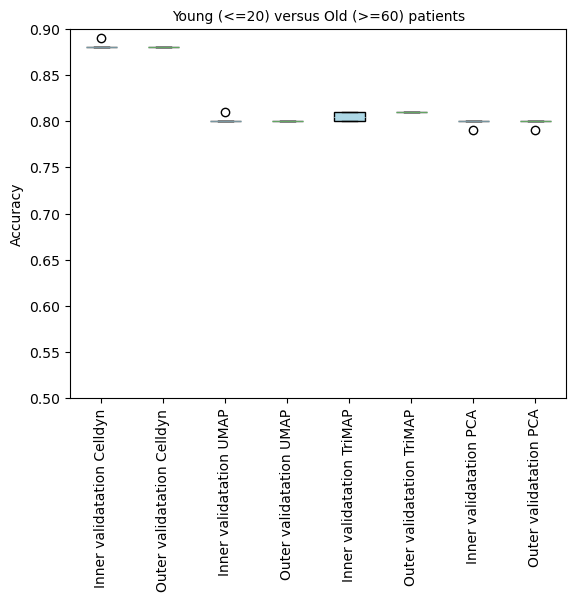

In [40]:
plt.style.use("default")


fig = plt.boxplot(
    [
        inner_validation_org['acc'],outer_validation_org['acc'],
        inner_validation_emb['acc'],outer_validation_emb['acc'],
        inner_validation_trimap['acc'],outer_validation_trimap['acc'],
        inner_validation_pca['acc'],inner_validation_pca['acc']
        
    ],
    labels=[
    'Inner validatation Celldyn','Outer validatation Celldyn',
    'Inner validatation UMAP','Outer validatation UMAP',
    'Inner validatation TriMAP','Outer validatation TriMAP',
    'Inner validatation PCA','Outer validatation PCA'
    ],
    patch_artist=True,
)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize = 10)

colors = ['lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen']
for patch,median, color in zip(fig['boxes'],fig['medians'], colors):
    patch.set_facecolor(color)
    median.set_color(color)
    median.set_linewidth(0.5)

plt.ylabel("Accuracy",fontdict=dict(size = 10))
plt.ylim(0.5,0.9)
plt.title("Young (<=20) versus Old (>=60) patients",fontdict=dict(size=10))


plt.savefig("../artifacts/young_vs_young_acc.png",dpi = 300,bbox_inches='tight')
plt.savefig("../artifacts/young_vs_young_acc.eps",dpi = 300,bbox_inches='tight')


# plt.boxplot([outer_validation_org['acc'],outer_validation_emb['acc']],labels=['title 1','title 2'])


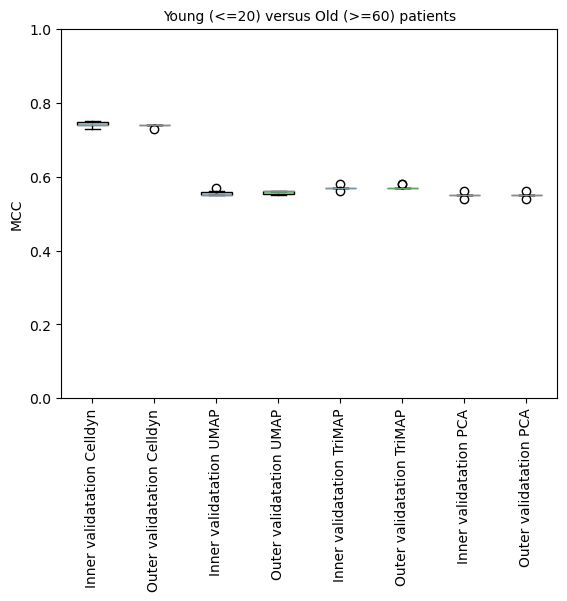

In [41]:

fig = plt.boxplot(
    [
        inner_validation_org['MCC'],outer_validation_org['MCC'],
        inner_validation_emb['MCC'],outer_validation_emb['MCC'],
        inner_validation_trimap['MCC'],outer_validation_trimap['MCC'],        
        inner_validation_pca['MCC'],inner_validation_pca['MCC']
        
    ],
    labels=[
    'Inner validatation Celldyn','Outer validatation Celldyn',
    'Inner validatation UMAP','Outer validatation UMAP',
    'Inner validatation TriMAP','Outer validatation TriMAP',
    'Inner validatation PCA','Outer validatation PCA'
    ],
    patch_artist=True,
)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(fontsize = 10)


colors = ['lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen','lightblue', 'lightgreen']
for patch,median, color in zip(fig['boxes'],fig['medians'], colors):
    patch.set_facecolor(color)
    median.set_color(color)
    median.set_linewidth(0.5)

plt.ylabel("MCC",fontdict=dict(size = 10))
plt.ylim(0,1)
plt.title("Young (<=20) versus Old (>=60) patients",fontdict=dict(size=10))


plt.savefig("../artifacts/young_vs_young_mcc.png",dpi = 300,bbox_inches='tight')
plt.savefig("../artifacts/young_vs_young_mcc.eps",dpi = 300,bbox_inches='tight')


# plt.boxplot([outer_validation_org['acc'],outer_validation_emb['acc']],labels=['title 1','title 2'])
